In [88]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import unicodedata

## Preprocessing et statistiques descriptives

In [135]:
transcriptions_df = pd.read_csv('transcriptions_with_sex.csv')
frequencies_df = pd.read_csv('firstname_with_sex.csv', sep=';')

####  Visualisation de la répartition des sexes

In [140]:
transcriptions_df[transcriptions_df['sex'] == 'ambigu']

,subject_line,groundtruth,prediction,sex
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu
130,623f7836-8a46-4078-914e-f3cb9bb51c6e,surname: Martin firstname: Marie occupation: i...,nom: Martin prénom: Marie date_naissance: 47 l...,ambigu
196,91b1d765-2195-462d-a85b-72233327ff4d,surname: Pénot firstname: Claude occupation: s...,nom: Pirot prénom: Claude date_naissance: 1303...,ambigu
204,a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c,surname: Coq firstname: Antonie occupation: id...,nom: d prénom: Entonie date_naissance: 16 lieu...,ambigu
230,e925d46e-1ea7-4537-986e-0fe062d64fa2,surname: Clayeux firstname: Claude occupation:...,nom: Clayeux prénom: Claude date_naissance: 13...,ambigu


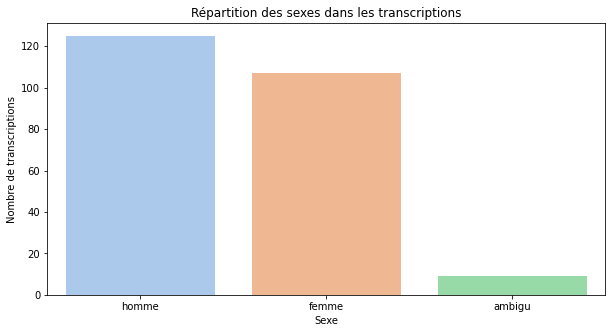

In [128]:
transcription_par_sexe = transcriptions_df['sex'].value_counts()

plt.figure(figsize=(10, 5))

sns.barplot(x=transcription_par_sexe.index, y=transcription_par_sexe.values, palette='pastel')

plt.title('Répartition des sexes dans les transcriptions')

plt.xlabel('Sexe')

plt.ylabel('Nombre de transcriptions')

plt.show()

On voit immédiatement que certaines personnes sont renseignés comme ayant un sexe ambigu dans la base transcription. Nous allons procéder par eliminer ces lignes de notre base de données.

In [129]:
transcriptions_df = transcriptions_df[transcriptions_df['sex'] != 'ambigu']

#### Visualisation des 10 prenoms les plus frequents (France, par sexe)

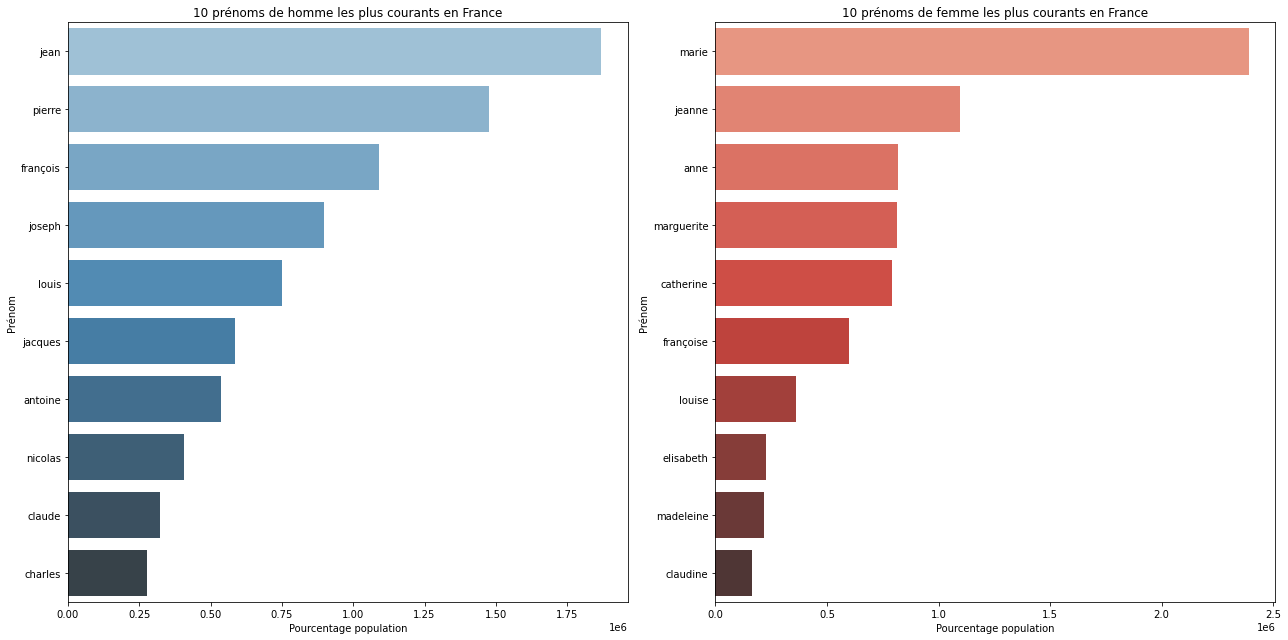

In [142]:
top_prenom_homme = frequencies_df.nlargest(10, 'male')[['firstname', 'male']]

top_prenom_femme = frequencies_df.nlargest(10, 'female')[['firstname', 'female']]


plt.figure(figsize=(18, 9))


plt.subplot(1, 2, 1)

sns.barplot(data=top_prenom_homme, x='male', y='firstname', palette='Blues_d')

plt.title('10 prénoms de homme les plus courants en France')

plt.xlabel('Pourcentage population')

plt.ylabel('Prénom')


plt.subplot(1, 2, 2)

sns.barplot(data=top_prenom_femme, x='female', y='firstname', palette='Reds_d')

plt.title('10 prénoms de femme les plus courants en France')

plt.xlabel('Pourcentage population')

plt.ylabel('Prénom')


plt.tight_layout()

plt.show()

#### Preprocessing de la colonne 'prediction' : creation de nouvelles colonnes

In [144]:
import re

def extraction_prediction(data, field):
    if field in ['relation', 'profession']:
        end_pattern = r"(?=\s+\w+:(?!.*\b(relation|profession)\b))"
    else:
        end_pattern = r"(?=\s+\w+:|$)"
    regex = rf"{field}: ([^:]*?){end_pattern}"
    return data['prediction'].apply(lambda x: re.search(regex, x, re.IGNORECASE).group(1) if re.search(regex, x, re.IGNORECASE) else None)

# Application du code amélioré sur les colonnes spécifiques
transcriptions_df['nom'] = extraction_prediction(transcriptions_df, 'nom')
transcriptions_df['prenom'] = extraction_prediction(transcriptions_df, 'prénom')
transcriptions_df['date_naissance'] = extraction_prediction(transcriptions_df, 'date_naissance')
transcriptions_df['education'] = extraction_prediction(transcriptions_df, 'éducation')
transcriptions_df['etat_civil'] = extraction_prediction(transcriptions_df, 'état_civil')
transcriptions_df['employeur'] = extraction_prediction(transcriptions_df, 'employeur')
transcriptions_df['lieu_naissance'] = extraction_prediction(transcriptions_df, 'lieu_naissance')
transcriptions_df['relation'] = extraction_prediction(transcriptions_df, 'relation')
transcriptions_df['profession'] = extraction_prediction(transcriptions_df, 'profession')

#### Combien de lignes non renseignées ?

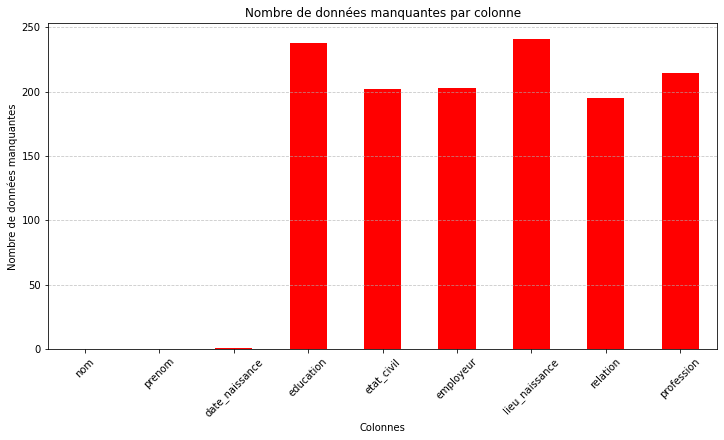

In [145]:
plt.figure(figsize=(12, 6))

colonnes_a_verifier = transcriptions_df[['nom', 'prenom', 'date_naissance', 'education', 'etat_civil', 'employeur', 'lieu_naissance', 'relation', 'profession']].isna().sum()
colonnes_a_verifier.plot(kind='bar', color='red')
plt.title('Nombre de données manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de données manquantes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [95]:
pd.unique(transcriptions_df['profession'])

array([None, 'id', 'cuisinière', 'domestique', 'culviciste', 'd°',
       'voiturier', 'entiiiateur', 'emp pils', 'Turaliste',
       'Cleve de motarie', 'charentier', 'sellier', 'manoeuvre',
       'polisseur', 'Employé', 'enttinateur', 'charesier', 'culsinière',
       'Menuisier', 'represt de pamis', 'Menseuvr', 'entiinateur',
       'femme'], dtype=object)

In [96]:
pd.unique(transcriptions_df['relation'])

array([None, 'id', 'C', 'Rouher', 'domestique', 'Gonde ponts Bores',
       'chef', 'Chemin', 'F', '"', 'fille', 'metages', 'nevur',
       'femme de chambre', 'd mestique', 'ép', "'h", 'ch', 'Chef',
       'ouvrier', 'frère', 'chacon', 'cullinière', 'fins', 'bru', 'Ep',
       'Ch', 'pard', 'femme', 'domest', 's p', 'coiffeur', 'par'],
      dtype=object)

In [97]:
pd.unique(transcriptions_df['etat_civil'])

array([None, 's', "'' ", 'D', 'id', 'v', 'mère', 'm', 's p ', "' ",
       'Cheus) ', 'Chef ', 'C', 'me', 'M ', 's p', 'S P ', 'sse',
       'Vitant ', 'V P ', 'V', 'M', 'meunicien', 'marns P ', 'Ch',
       'marnt', 's '], dtype=object)

On remarque que pour le peu de professions et de relations qui sont renseignés, elle sont le plus souvent mal renseignés. Parfois on peut aussi voir des "profession" dans les "relations". Par exemple, 'ouvrier' fait plutot référence au fait qu'un individu A est ouvrier "sous les ordres de" B

#### WordCloud des prenoms par sexe

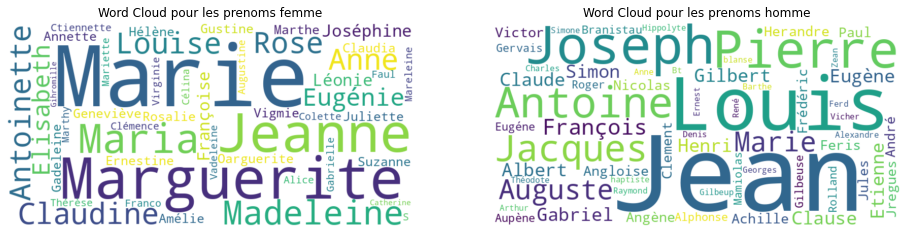

In [146]:
liste_prenoms_m = [str(nom) for nom in transcriptions_df[transcriptions_df['sex'] == 'homme']['prenom'].dropna().tolist()]
liste_prenoms_f = [str(nom) for nom in transcriptions_df[transcriptions_df['sex'] == 'femme']['prenom'].dropna().tolist()]


wordcloud_m = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(liste_prenoms_m))

wordcloud_f = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(liste_prenoms_f))


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(wordcloud_f, interpolation='bilinear')

axes[0].set_title('Word Cloud pour les prenoms femme')

axes[0].axis('off')

axes[1].imshow(wordcloud_m, interpolation='bilinear')

axes[1].set_title('Word Cloud pour les prenoms homme')

axes[1].axis('off')

plt.show()

#### On enleve les majuscules des prenoms

In [99]:
transcriptions_df['prenom'] = transcriptions_df['prenom'].str.lower()

## Modèles

#### Une simple heuristique pour commencer 

Ayant à notre disposition le fichier avec les fréquences de chaque prénom, on peut construire une heuristique très simple : si un prenom est plutot "feminin", on renvoie "femme", sinon "homme", sachant que dans le cas où nous n'avons pas de données, on renvoie "homme" par défaut, car il y a dans cette base plus d'hommes que de femmes

In [100]:
merged_df = pd.merge(transcriptions_df, frequencies_df, left_on='prenom', right_on='firstname', how='left')

In [101]:
merged_df

,subject_line,groundtruth,prediction,sex,nom,prenom,date_naissance,education,etat_civil,employeur,lieu_naissance,relation,profession,firstname,male,female
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,marie,30,None,None,None,None,None,None,marie,10145.0,2390322.0
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,louis jean,67,None,None,ahef,None,None,None,NaN,NaN,NaN
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Pyrin,marie,55,None,None,None,None,None,None,marie,10145.0,2390322.0
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,marie,1875,None,None,None,None,None,None,marie,10145.0,2390322.0
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,marguerite,78,None,None,None,None,None,None,marguerite,1441.0,813859.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme,Burlurut,gihromille,61,None,None,None,None,None,None,NaN,NaN,NaN
228,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme,Comberf,alexandre,59,None,None,None,None,par,None,alexandre,90238.0,413.0
229,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme,Collin,marguerite,38,None,None,None,None,None,femme,marguerite,1441.0,813859.0
230,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme,Dumont,etienne,1900,None,None,None,None,None,None,etienne,211297.0,898.0


In [102]:
def regle_sexe(ligne):
    if ligne['male'] > ligne['female']:
        return 'homme'
    else:
        return 'femme'
    
merged_df['predicted_sex'] = merged_df.apply(regle_sexe, axis=1)


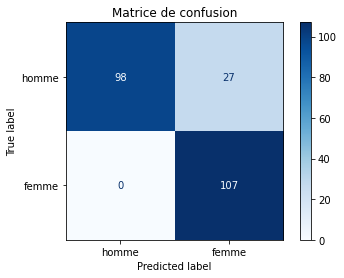

In [103]:
labels = ['homme', 'femme']  
cm = confusion_matrix(merged_df['sex'], merged_df['predicted_sex'], labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()

On voit que cette heuristique, quoique simpliste, arrive déjà assez bien à la plupart des individus dans la catégorie qui leur corréspond. On remarque aussi que le modèle a du mal avec des individus de sexe feminin qu'il prédit comme étant de sexe masculin, car ayant des prénoms mixtes comme 'Marie', 'Camille', ...

Ce modèle pourrait encore être amélioré si l'on prend en compte d'autres colonnes comme la profession (on peut voir "cuisinière", "femme", ...) mais encore la colonne relation ("femme de chambre", "fille", "chef") ou la colonne etat civil ('mere', 'Chef', ...) qui nous renseignent davantage sur le sexe des individus. Toutefois, il y a également beaucoup de données manquantes dans ces colonnes

#### XGBoost

Maintenant, on revient sur le dataframe transcription_df. Nous allons vectoriser 

In [104]:
# On fait l'encoding de la variable "sexe" : 0 pour homme, 1 pour femme

transcriptions_df['sex'] = transcriptions_df['sex'].apply(lambda x: 0 if x=='homme' else 1)

In [105]:
transcriptions_df

,subject_line,groundtruth,prediction,sex,nom,prenom,date_naissance,education,etat_civil,employeur,lieu_naissance,relation,profession
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,1,Chardon,marie,30,None,None,None,None,None,None
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,0,Lhopital,louis jean,67,None,None,ahef,None,None,None
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,1,Pyrin,marie,55,None,None,None,None,None,None
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,1,Lavocat,marie,1875,None,None,None,None,None,None
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,1,Benne,marguerite,78,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,1,Burlurut,gihromille,61,None,None,None,None,None,None
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,0,Comberf,alexandre,59,None,None,None,None,par,None
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,1,Collin,marguerite,38,None,None,None,None,None,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,0,Dumont,etienne,1900,None,None,None,None,None,None


In [106]:
X = transcriptions_df.drop('sex', axis=1)["prediction"]
y = transcriptions_df['sex']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tfidf_vect = TfidfVectorizer()
bow_vect = CountVectorizer()

In [117]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

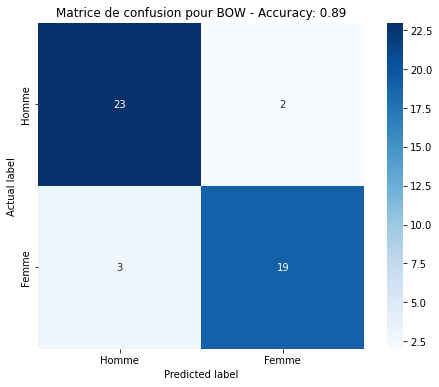

BOW: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


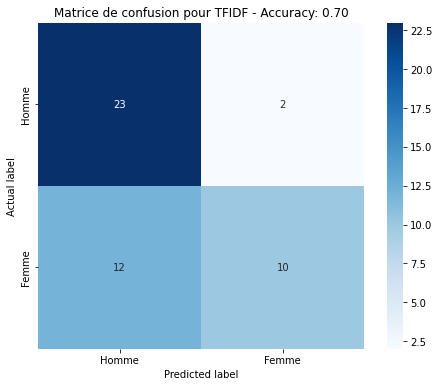

TFIDF: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [120]:
results = {}

vectorizers = {
    "BOW": bow_vect,
    "TFIDF": tfidf_vect
}

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
    grid_search.fit(X_train_vec, y_train)
    
    best_xgb_model = grid_search.best_estimator_
    
    y_pred = best_xgb_model.predict(X_test_vec)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[vec_name] = {
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'best_params': grid_search.best_params_
    }

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
                xticklabels=['Homme', 'Femme'], yticklabels=['Homme', 'Femme'])
    plt.title(f'Matrice de confusion pour {vec_name} - Accuracy: {accuracy:.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print(f"{vec_name}: {grid_search.best_params_}")